# PROJECT SUMMARY: WHICH DISEASES ARE COMORBID WITH OBESITY?

## Overview

This project was given to me as a data science exercise. The "who gave it to me" and "why" parts don't matter here, only the "what did they want" and the "how did they want me to do it". The goal of the project is to determine which diseases or syndromes are *comorbid* with obesity. In other words, the goal is to determine which diseases occur at higher rates in obese populations relative to non-obese populations. All of the data must come from PubMed/MEDLINE databases that are part of the National Center for Biotechnology Information (NCBI).

## Methods

Some of the methods for this project are required, and others are left for me to decide. The initial, expected workflow is as follows:

1. Retrieve the records for all papers published between 2000 and 2012 that have the term 'Obesity' as a major topic (note: 'Obesity' and 'Obesity, Morbid' are two different descriptors, but records containing either as major topics are returned using 'Obesity')
2. Using the list of all possible medical descriptors (MeSH terms), create a smaller list of terms that only refer to diseases or syndromes
3. Identify which papers talk about each disease in the new list, and extract any relevant data (number of references, odds ratio values, etc.)
4. Try to answer the question, if possible: which diseases are comorbid with obesity?

Documentation for the Entrez APIs (to access the PubMed data) can be found here:
[Entrez Documentation](https://www.ncbi.nlm.nih.gov/books/NBK25501/)

## Desired Output

The ultimate goal of the project is to determine which diseases have a higher incidence rates in obese populations relative to non-obese populations (odds ratios > 1). The goal is *NOT* to determine which diseases are more severe in obese populations. You can see an illustration of the desired output in the next section.

It's important to note that this is a **Descriptive** study, and not a **Predictive** or **Prescriptive** study. The goal here is to understand what the existing data says, not to build machine learning models or decision trees (proper ones, for actually making decisions).

## Data Limitation

One of the key assumptions that will be carried through the rest of this project is that odds ratios, statistical significances, etc. are *NOT* stored in the publication record metadata. The only place that data can be retrieved (using the approach requested) is via the abstracts. If I'm wrong, and the metadata *DOES* store that information, this project is a whole lot easier!

# SECTION 0: EXAMPLE OF WHAT WE WANT

This section below generates a synthetic dataset using Monte Carlo techniques to highlight the type of visual (and statistical) product that we want. This is just meant to be a guide so that visually-inclined readers can see the "single figure summary" that we're after.

## Setting Up the Environment

This section imports the main math and plotting libraries that we'll use throughout the project

In [17]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Defining the Function

This section creates the function that generates a synthetic dataset for our example plot

In [18]:
def create_synthetic_OR_plot():
    X_locations = [x for x in range(0,10)]
    X_labels = [chr(x+65) for x in range(0,10)]

    data = []
    means = {}

    for location in X_locations:
        p_disease_not_obesity = np.random.random_sample() * (0.5) + 0.02
        p_disease_obesity = np.random.random_sample() * (0.5) + 0.12
        papers = int(np.random.random_sample() * (100-5) + 1)
        disease_results = []
        for i in range(0,papers):
            observations = int(np.random.random_sample() * (1000 - 100) + 100)
            bias_disease_not_obesity = np.random.random_sample() * (0.2) - 0.1
            bias_disease_obesity = np.random.random_sample() * (0.2) - 0.1
            p_eff_disease_not_obesity = p_disease_not_obesity + bias_disease_not_obesity
            p_eff_disease_obesity = p_disease_obesity + bias_disease_obesity
            p_eff_disease_not_obesity = max(0.01,min(p_eff_disease_not_obesity,0.99))
            p_eff_disease_obesity = max(0.01,min(p_eff_disease_obesity,0.99))
            samples_disease_not_obesity = np.random.binomial(1, p_eff_disease_not_obesity, observations)
            samples_disease_obesity = np.random.binomial(1, p_eff_disease_obesity, observations)
            fraction_disease_not_obesity = sum(samples_disease_not_obesity) / observations
            fraction_disease_obesity = sum(samples_disease_obesity) / observations
            if fraction_disease_not_obesity != 0:
                odds_ratio = fraction_disease_obesity / fraction_disease_not_obesity
                disease_results.append(odds_ratio)
        data.append(disease_results)
        means[location] = np.mean(disease_results)

    sorted_locs = sorted(means, key=means.__getitem__, reverse=True)
    data_sorted = []
    labels_sorted = []
    for i in range(0,len(X_locations)):
        data_sorted.append(data[sorted_locs[i]])
        labels_sorted.append(X_labels[sorted_locs[i]])

    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(1,1,1)
    ax.boxplot(data_sorted)
    ax.plot([0,11],[1,1],color="black")
    ax.set_yscale('log')
    ax.set_xticklabels(labels_sorted)
    ax.set_xlabel("Disease or Syndrome")
    ax.set_ylabel("P(Disease|Obesity) / P(Disease|NotObesity)")
    ax.set_title("Synthetic Data Showing Diseases Ranked By Mean Odds Ratios")
    plt.show()

## Running the Function to Generate an Example Plot

Re-run this section below to see how the randomness in the function can create a range of variances!

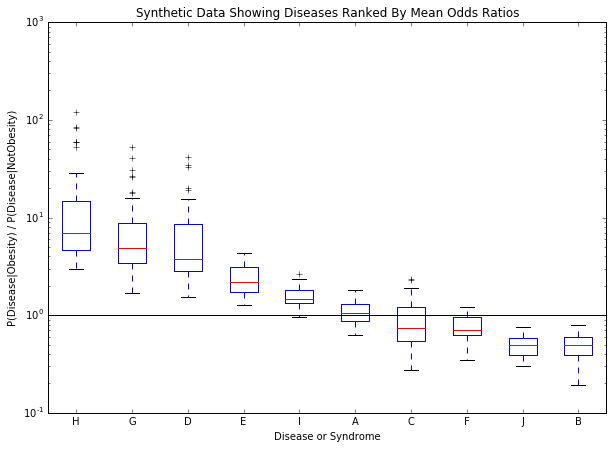

In [19]:
create_synthetic_OR_plot()

# SECTION 1: GETTING THE API DATA

This section is a one-time-use block of code meant to download the relevant data from the Entrez PubMed database and write it to a file. All future references to the data will come from the file itself, to save network bandwidth.

**Storage Format for Each Publication:**

PUBMED_ID  
Number  
ABSTRACT  
Abstract text  
MESH  
List of MeSH terms

## Setting Up the Environment

This section imports the necessary modules to implement the API calls. The main package used for this section is the Entrez submodule from Biopython.

In [20]:
import time
from Bio import Entrez
Entrez.email = "brianjlevay@gmail.com"

## Defining the Function

This section defines a generic function for getting PubMed records and writing the relevant data to a file. The function accepts search terms and a filename as arguments. The flow is as follows:

1. Open a file for writing
2. Perform an initial pubmed search (eSearch), and store the results on the server (usehistory)
3. Iteratively perform API calls (eFetch) to get the results, 10000 at a time
4. Write the relevant parts of each result (number, abstract, and mesh terms) to a file
5. Close the file

In [21]:
def get_api_data(terms, filename):
    f = open(filename + '.txt', 'w')
    
    handle = Entrez.esearch(db='pubmed', term=terms, usehistory='y')
    search = Entrez.read(handle)
    handle.close()

    count = int(search['Count'])
    query = search['QueryKey']
    web = search['WebEnv']
    print("{} records found through eSearch.".format(count))
    
    max_ret = 10000
    steps_tot = math.ceil(count / max_ret)
    steps = [x*max_ret for x in range(0,steps_tot)]
    total_records = 0
    
    for step in steps:
        time.sleep(30)
        handle = Entrez.efetch(db='pubmed', query_key=query, WebEnv=web, retmode='xml', retstart=step, retmax=max_ret)
        fetch = Entrez.read(handle)
        handle.close()
        print("Step {}: API batch returned.".format(step))
    
        for entry in fetch:
            total_records += 1
            f.write('PUBMED_ID\n')
            f.write(entry['PubmedData']['ArticleIdList'][0] + '\n')
            f.write('ABSTRACT\n')
            try:
                abstract = entry['MedlineCitation']['Article']['Abstract']['AbstractText'][0]
                if abstract == '':
                    abstract = 'No abstract available'
                try:
                    f.write(abstract + '\n')
                except:
                    try:
                        abstract = abstract.encode('cp1252', 'replace').decode('cp1252')
                        f.write(abstract + '\n')
                    except:
                        f.write('Abstract could not be printed.\n')
            except:
                f.write('No abstract available.\n')
            f.write('MESH\n')
            mesh_str = ''
            for mesh in entry['MedlineCitation']['MeshHeadingList']:
                mesh_str += mesh['DescriptorName'] + '; '
            f.write(mesh_str[0:len(mesh_str)-2] + '\n')    
            f.write('\n')
    
    f.close()
    print("{} records retrieved via eFetch and written to the file.".format(total_records))

## Running the Function to Gather the Data

This block of code uses the generalized function defined above to retrieve the data from PubMed. This function only needs to be run once, and afterwards, the data will be stored in a local file.

In [22]:
# Need to specify obesity as the major MeSH descriptor (MajorTopicYN="Y") [majr] vs [majr:noexp]

obesity_terms = 'obesity[majr] 2000:2012[pdat]'

# Only need to run this function once to get all of the relevant API data

# get_api_data(obesity_terms, 'obesity_pubmed')

59515 records found through eSearch.
Step 0: API batch returned.
Step 10000: API batch returned.
Step 20000: API batch returned.
Step 30000: API batch returned.
Step 40000: API batch returned.
Step 50000: API batch returned.
59515 records retrieved via eFetch and written to the file.


# SECTION 2: CATEGORIZING MESH TERMS

This section uses the MeSH definitions file (desc2015.xml) to create a list of terms that refer to "Disease or Syndrome". The list will then be used to filter the MeSH terms in the publication results.

The MeSH descriptors file is large, so it will not be stored along with this code and the intermediate data products. Instead, you can download it from the following ftp site. I did not directly link the file below, because this is one you don't want to accidently start downloading with a careless click!

[Location for File](ftp://nlmpubs.nlm.nih.gov/online/mesh/2015/)

## Setting Up the Environment

This section imports BeautifulSoup, which is used for XML parsing.

In [23]:
from bs4 import BeautifulSoup

## Defining the XML Parsing Function

The source file for the MeSH terms is a large (~300 MB) xml file, and my preferred XML parser (BeautifulSoup) doesn't perform very well under such a load. So, for this exercise, I will initially split the XML file into chunks using basic string techniques, and then I will apply the parser to each fragment. This is slow, but the memory footprint is smaller and it runs without crashing. I know there are better XML libraries, but this is what I've got for now.

This function opens the definitions file, extracts only the descriptors that match a SemanticTypeName specified as an argument, and writes those terms to another file. It's important to note that this function only considers semantic types listed under the preferred concept!

In [24]:
def get_descriptors(semantic_type, filename):
    f = open('desc2015.xml', 'r')
    xml_contents = f.read()
    f.close()

    f = open(filename + '.txt', 'w')

    header_content = '<?xml version="1.0"?>\n' + '<!DOCTYPE DescriptorRecordSet SYSTEM "desc2015.dtd">\n' + \
        '<DescriptorRecordSet LanguageCode = "eng">\n' + '<DescriptorRecord DescriptorClass = "1">\n'
    xml_contents = xml_contents.replace(header_content, '')
    descriptors = xml_contents.split('</DescriptorRecord>\n<DescriptorRecord DescriptorClass = "1">')

    for descriptor in descriptors:
        descriptor = '<DescriptorRecord DescriptorClass = "1">\n' + descriptor + '</DescriptorRecord>'
        desc_soup = BeautifulSoup(descriptor, "xml")
        name = desc_soup.DescriptorName.String.get_text()
        semantic_tags = desc_soup.ConceptList.find('Concept', PreferredConceptYN='Y').find_all('SemanticTypeName')
        semantic_types = set()
        for tag in semantic_tags:
            semantic_types.add(tag.get_text())
        if semantic_type in semantic_types: 
            f.write(name + "\n")
    
    f.close()

## Running the Function to Output the Descriptors

This block of code runs the function defined above to generate a file with a list of applicable descriptors. You only need to run this once, and all future data access will come from the newly created file.

In [25]:
# Only need to run this function once to get all of the relevant terms

# get_descriptors('Disease or Syndrome', 'mesh_disease_syndrome_terms')

# SECTION 3: READING THE DATA FROM THE FILES

This section loads the data from the raw PubMed records (previously stored from the API calls) and the disease terms (previously stored from the descriptors list) into their respective data structures for use.

In [33]:
f = open('mesh_disease_syndrome_terms.txt', 'r')
disease_terms = f.read()
f.close()

disease_terms = disease_terms.split('\n')
print("{} terms in the disease list.".format(len(disease_terms)))

f = open('obesity_pubmed.txt', 'r')
pubmed_raw = f.read()
f.close()

pubmed_raw = pubmed_raw.split('\n\n')
pubmed_raw = pubmed_raw[0:len(pubmed_raw)-1]
print("{} records in the raw PubMed data.".format(len(pubmed_raw)))

pubmed_records = []
for record in pubmed_raw:
    record_dict = {}
    lines = record.split('\n')
    record_dict['ID'] = lines[1]
    record_dict['ABSTRACT'] = lines[3]
    record_dict['MESH'] = lines[5].split("; ")
    pubmed_records.append(record_dict)
    
print("\nEXAMPLE RECORD")
for item in pubmed_records[0]:
    print("{0}: {1}".format(item,pubmed_records[0][item]))

2989 terms in the disease list.
59515 records in the raw PubMed data.

EXAMPLE RECORD
ID: 25548090
ABSTRACT: The aim is to determine the appropriate cutoff values of waist circumference (WC) for an increased risk of the metabolic syndrome in the Korean elderly population. We analyzed the WC cutoff values of four groups divided according to sex and age with a total of 2,224 elderly participants aged 65 years old and above from the Fourth Korean National Health and Nutrition Examination Survey using the receiver operating characteristic curve and multiple logistic regression. The WC cutoff values associated with an increased risk of metabolic syndrome were 89.6 cm for men and 90.5 cm for women for those who were 65 to 74 years old, and 89.9 cm for men and 87.9 cm for women for those who were 75 years old or older. WC cutoff points for estimating metabolic risk are similar in elderly men and women. Age-specific optimal WC cutoff points should be considered especially for elderly women in 

# SECTION 4: COUNTING PAPERS THAT MENTION DISEASES

This section determines the number of papers that mention each disease as a MeSH keyword. It's important to note that the number of papers talking about a disease (in conjunction with obesity) actually tells us nothing about comorbidity, unless we make some strong assumptions. Some possible explanations for why disease A is talked about more than disease B:

1. Disease 'A' has a higher odds ratio than disease 'B', so 'A' gets more attention (what we want to know)
2. Disease 'A' is much more severe than disease 'B', so 'A' gets more attention
3. The comorbidity or severity of disease 'A' is harder to ascertain than disease 'B', and therefore more studies have been conducted to try to reduce the uncertainty
4. Disease 'A' may have more treatment options available and/or is considered easier to treat, so 'A' gets more attention
5. The research groups that study disease 'A' might just prefer breaking up their studies into smaller papers, or they might just publish more papers in general when compared to groups that focus on disease 'B'

There are almost certainly other reasons not outlined above. I'll talk about these issues more, in a bit.